In [1]:
import sys; print('Python \t\t{0[0]}.{0[1]}'.format(sys.version_info))
import tensorflow as tf; print('Tensorflow \t{}'.format(tf.__version__))
import keras; print('Keras \t\t{}'.format(keras.__version__))

Python 		3.6
Tensorflow 	1.0.0


Using TensorFlow backend.


Keras 		2.0.3


In [2]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../mnist-data/", one_hot=True)

Extracting ../mnist-data/train-images-idx3-ubyte.gz
Extracting ../mnist-data/train-labels-idx1-ubyte.gz
Extracting ../mnist-data/t10k-images-idx3-ubyte.gz
Extracting ../mnist-data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape

(55000, 784)

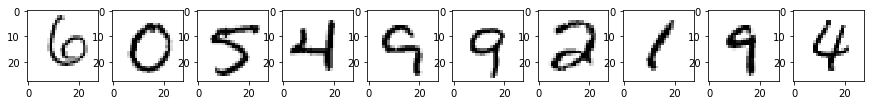

In [5]:
plt.figure(figsize=(15,5))
for i in list(range(10)):
    plt.subplot(1, 10, i+1)
    pixels = mnist.test.images[i+100]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
plt.show()

In [6]:
import tensorflow as tf
import tensorlayer as tl

In [7]:
# Set parameters
training_iteration = 10
batch_size = 250
display_step = 5

FLAGS = None

In [8]:
# TF graph input
x = tf.placeholder('float', [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder('float', [None,10]) # 0-9 digits recognition => 10 classes

In [9]:
network = tl.layers.InputLayer(x, name='input_layer')
network = tl.layers.DenseLayer(network, n_units=512,act = tf.nn.relu, name='relu1')
network = tl.layers.DropoutLayer(network, keep=0.75, name='drop1')
network = tl.layers.DenseLayer(network, n_units=512,act = tf.nn.relu, name='relu2')
network = tl.layers.DropoutLayer(network, keep=0.75, name='drop2')
network = tl.layers.DenseLayer(network, n_units=10,act = tl.activation.identity, name='output_layer')

# unscaled output (log probabilities)
y_hat = network.outputs

# scaled output
y_out = tf.nn.softmax(y_hat)

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 512 relu
  [TL] DropoutLayer drop1: keep:0.750000 is_fix:False
  [TL] DenseLayer  relu2: 512 relu
  [TL] DropoutLayer drop2: keep:0.750000 is_fix:False
  [TL] DenseLayer  output_layer: 10 identity


In [10]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_hat))

In [11]:
train_params = network.all_params
with tf.name_scope("train") as scope:
    # Gradient descent
    optimizer = tf.train.AdamOptimizer()
    learn     = optimizer.minimize(cost, var_list=train_params)

In [12]:
# Initializing the variables
init = tf.global_variables_initializer()

# Merge all summaries into a single operator
merged_summary_op = tf.summary.merge_all()

In [13]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)

In [14]:
# Change this to a location on your computer
summary_writer = tf.summary.FileWriter('./tensorboard/tf', graph=sess.graph)

In [15]:
# Test the model, Calculate accuracy
prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(prediction, tf.float32))

In [16]:
# train the network
tl.utils.fit(sess, network, learn, cost, mnist.train.images, mnist.train.labels, x, y,
             acc=acc, batch_size=batch_size, n_epoch=training_iteration, print_freq=display_step, 
             X_val=mnist.test.images, y_val=mnist.test.labels, eval_train=False)


Start training the network ...
Epoch 1 of 10 took 3.713975s
   val loss: 0.130056
   val acc: 0.960200
Epoch 5 of 10 took 4.119508s
   val loss: 0.065117
   val acc: 0.979400
Epoch 10 of 10 took 4.020873s
   val loss: 0.067738
   val acc: 0.980500
Total training time: 41.109480s


In [17]:
# evaluation
tl.utils.test(sess, network, acc, mnist.test.images, mnist.test.labels, x, y, batch_size=None)

Start testing the network ...
   test acc: 0.980500


In [18]:
dp_dict = tl.utils.dict_to_one( network.all_drop )
dp_dict

{<tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>: 1,
 <tf.Tensor 'Placeholder_3:0' shape=<unknown> dtype=float32>: 1}

In [19]:
# test item #100 is a "six"
pixels = mnist.test.images[100]

feed_dict = {x:[pixels]}
feed_dict.update(dp_dict)

result = sess.run(y_out, feed_dict=feed_dict)
dict(zip(range(10), result[0]))

{0: 5.2470352e-07,
 1: 1.4410477e-09,
 2: 6.4901751e-09,
 3: 9.6050971e-12,
 4: 1.8693913e-09,
 5: 2.8257659e-08,
 6: 0.99999952,
 7: 4.9972051e-11,
 8: 1.3550721e-09,
 9: 1.0239229e-11}

In [20]:
def test_render(pixels, result, truth):
    #pixels, result and truth are np vectors
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')

    plt.subplot(1, 2, 2)
    
    #index, witdh
    ind = np.arange(len(result))
    width = 0.4

    plt.barh(ind,result, width, color='orange', edgecolor='k', hatch="/")
    plt.barh(ind+width,truth,width, color='g', edgecolor='k')
    plt.yticks(ind+width, range(10))
    plt.margins(y=0)

    plt.show()

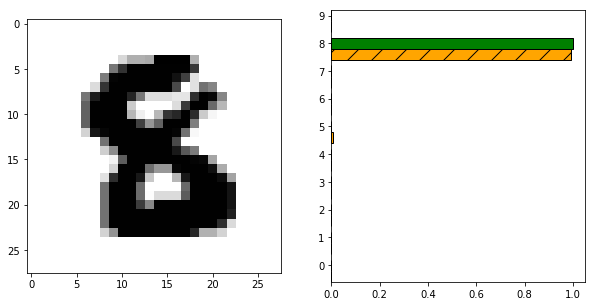

In [21]:
import random
i = random.randint(0,mnist.test.images.shape[0])

pixels = mnist.test.images[i]
truth  = mnist.test.labels[i]

feed_dict = {x:[pixels]}
feed_dict.update(dp_dict)
result = sess.run(y_out, feed_dict=feed_dict)[0]

test_render(pixels, result, truth)

In [22]:
### What went wrong?
pixels = mnist.test.images
truth = mnist.test.labels

feed_dict = {x:pixels}
feed_dict.update(dp_dict)
result = sess.run(y_out, feed_dict=feed_dict)

In [23]:
acc = result.argmax(axis=1) == truth.argmax(axis=1)
incorrect = np.argwhere(acc==False).flatten()

print("Incorrect predictions: {}".format(len(incorrect)))

Incorrect predictions: 195


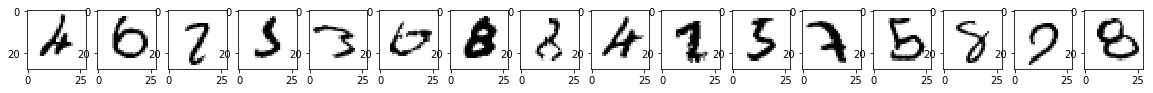

In [24]:
plt.figure(figsize=(20,5))
plt_idx = 1
for i in list(incorrect[:16]):
    plt.subplot(1, 16, plt_idx)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
    plt_idx += 1
plt.show()

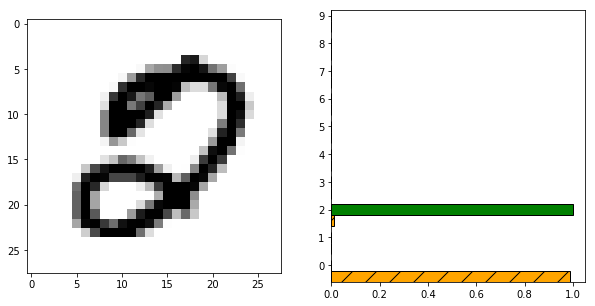

In [25]:
i = random.choice(list(incorrect))

pixels = mnist.test.images[i]
truth  = mnist.test.labels[i]

feed_dict = {x:[pixels]}
feed_dict.update(dp_dict)
result = sess.run(y_out, feed_dict=feed_dict)[0]

test_render(pixels, result, truth)

In [ ]:
# Close the Session when we're done.
sess.close()